In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pylab as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import os

2024-04-26 07:24:13.379713: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 07:24:13.379878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 07:24:13.518170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Formatting the Data:**

In [3]:
#assign the pathway to the kaggle dataset's training folder as the variable "train_folder"
train_folder = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
all_data = []
#travel through everything in the training data to get the label and path and add it to all_data
for folder in os.listdir(train_folder):
	label_folder = os.path.join(train_folder, folder)
	onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
	all_data += onlyfiles
#create a data frame with all the labels and pathways
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
1,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
2,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
3,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
4,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
...,...,...
86995,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86996,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86997,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86998,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...


In [4]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.25, random_state=42,stratify=x_train[['label']])

In [5]:
#Convert pandas DataFrames to TensorFlow Datasets
#train_dataset = tf.data.Dataset.from_tensor_slices((x_train.drop(columns=['label']).values, x_train['label'].values))
#holdout_dataset = tf.data.Dataset.from_tensor_slices((x_holdout.drop(columns=['label']).values, x_holdout['label'].values))
#test_dataset = tf.data.Dataset.from_tensor_slices((x_test.drop(columns=['label']).values, x_test['label'].values))

**Image Extraction:**

In [6]:
def augment_data(image):
    
    if tf.random.uniform((),minval=0,maxval=1) <0.05:
        image = tf.image.flip_left_right(image)
        
        
#     grayscale
    
#     saturation
    
#     brightness
    
#     roation: rotated = tf.image.rot90(image) rotates 90% but we would want random rotation within a smaller range...and then still square???
        
#     tf.image.stateless_random_hue
    
#     tf.image.stateless_random_jpeg_quality    
        
        
    return image

In [7]:
img_width, img_height = 64, 64
batch_size = 256
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0, preprocessing_function=augment_data) #augements data using function we made

train_generator = train_datagen.flow_from_dataframe(
	dataframe=x_train,x_col=x_col, y_col=y_col,
	target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
	shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
	dataframe=x_test, x_col=x_col, y_col=y_col,
	target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
	shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
	dataframe=x_holdout, x_col=x_col, y_col=y_col,
	target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
	shuffle=False
)

Found 58725 validated image filenames belonging to 29 classes.
Found 19575 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


**Building the Model**

In [8]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3))) # why does input shape change to 150
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(256))
# model.add(Activation('relu'))
model.add(Dense(29, activation = "softmax"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [9]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 893,085 (3.41 MB)

 Trainable params: 893,085 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

batch_size=128
epochs=1

history = model.fit(train_generator,
                	epochs=epochs,
                	verbose=1,
                	validation_data=validation_generator,
                	callbacks = [early_stop])

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


230/230 ━━━━━━━━━━━━━━━━━━━━ 982s 4s/step - accuracy: 0.1850 - loss: 2.8436 - val_accuracy: 0.8530 - val_loss: 0.4949


**Using the Model (testing)**

In [11]:
def idx_to_letter(idx):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    idx = idx[0]
    if 0 <= idx < len(letters):
        return letters[idx]
    if idx == 26:
        return 'nothing'
    if idx == 27:
        return '(space)'

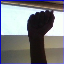

In [12]:
image_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg'
image = keras.utils.load_img(image_path, target_size = (64,64))
image

In [13]:
input_data = keras.utils.img_to_array(image)
input_data = np.expand_dims(input_data, axis=0)

In [14]:
prediction = model.predict(input_data)
print(prediction)

classes = np.argmax(prediction, axis = 1)
print(idx_to_letter(classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
a


In [15]:
image_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/C_test.jpg'
image = keras.utils.load_img(image_path, target_size = (64,64))
input_data = keras.utils.img_to_array(image)
input_data = np.expand_dims(input_data, axis=0)
prediction = model.predict(input_data)

classes = np.argmax(prediction, axis = 1)
print(idx_to_letter(classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
c


In [16]:
image_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/Z_test.jpg'
image = keras.utils.load_img(image_path, target_size = (64,64))
input_data = keras.utils.img_to_array(image)
input_data = np.expand_dims(input_data, axis=0)
prediction = model.predict(input_data)

classes = np.argmax(prediction, axis = 1)
print(idx_to_letter(classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
l


**Saving the Model Weights**

https://www.tensorflow.org/tutorials/keras/save_and_load#:~:text=To%20save%20weights%20manually%2C%20use,Save%20and%20load%20models%20guide.

In [17]:
pip install pyyaml h5py 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [19]:
model.save_weights('./weights.weights.h5')

in new script:

In [20]:
def make_cool_model():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
    model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3))) # why does input shape change to 150
    model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
    model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
    model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

    model.add(Flatten())
    model.add(Dense(256))
    # model.add(Activation('relu'))
    model.add(Dense(29, activation = "softmax"))
    model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
    return model

In [22]:
new_model = make_cool_model()
new_model.load_weights('./weights.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [23]:
image_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/C_test.jpg'
image = keras.utils.load_img(image_path, target_size = (64,64))
input_data = keras.utils.img_to_array(image)
input_data = np.expand_dims(input_data, axis=0)
prediction = new_model.predict(input_data)

classes = np.argmax(prediction, axis = 1)
print(idx_to_letter(classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
c
